In [13]:
import numpy as np
import matplotlib as mpl
mpl.use('pgf')

def textwidth_to_inch(scale):
    fig_width_pt = 427.3153                         # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    return fig_width_pt*inches_per_pt*scale         # width in inches

def figsize(scale):
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = textwidth_to_inch(scale)
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(0.9),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width):
    plt.clf()
    fig = plt.figure(figsize=figsize(width))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename):
    plt.savefig('../../text/figures/plots/{}.pgf'.format(filename), bbox_inches='tight')
    plt.savefig('../../text/figures/plots/{}.pdf'.format(filename), bbox_inches='tight')

%matplotlib inline

import pandas as pd

import json
import glob
import os

from math import log

/home/eagle/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
data = {}

for path in glob.glob(os.path.expanduser("~/dev/ma/data/results/lp_scaling/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [3]:
frames['program_run']['worker_label'] = frames['program_run']['hosts'].map(str) + 'x' + frames['program_run']['workers_per_host'].map(str)

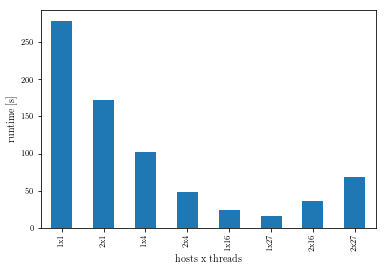

In [4]:
ax = frames['program_run'] \
    .loc[lambda x: x.node_count == 1000000] \
    .sort_values(by='total_workers') \
    .plot.bar(x='worker_label', y='runtime', legend=False)
    
ax.set_ylabel("runtime [s]")
ax.set_xlabel("hosts x threads")

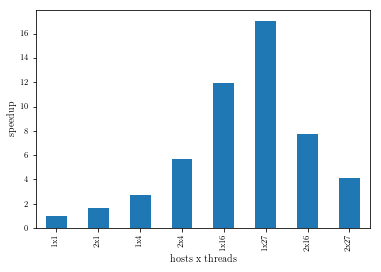

In [5]:
plot_data = frames['program_run'] \
    .loc[lambda x: x.node_count == 1000000] \
    .sort_values(by='total_workers')
    
plot_data['speedup'] = plot_data['runtime'].iloc[0] / plot_data['runtime']
    
ax = plot_data.plot.bar(x='worker_label', y='speedup', legend=False)
    
ax.set_ylabel("speedup")
ax.set_xlabel("hosts x threads")

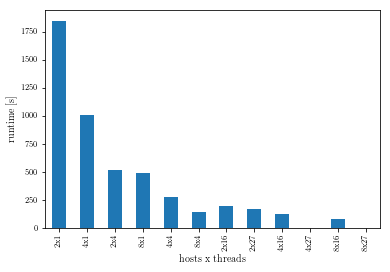

In [12]:
ax = frames['program_run'] \
    .loc[lambda x: x.node_count == 10000000] \
    .sort_values(by='total_workers') \
    .plot.bar(x='worker_label', y='runtime', legend=False)
    
ax.set_ylabel("runtime [s]")
ax.set_xlabel("hosts x threads")

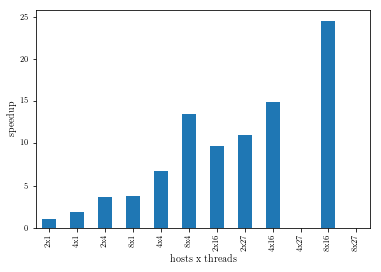

In [8]:
plot_data = frames['program_run'] \
    .loc[lambda x: x.node_count == 10000000] \
    .sort_values(by='total_workers')
    
plot_data['speedup'] = plot_data['runtime'].iloc[0] / plot_data['runtime']
    
ax = plot_data.plot.bar(x='worker_label', y='speedup', legend=False)
    
ax.set_ylabel("speedup")
ax.set_xlabel("hosts x threads")

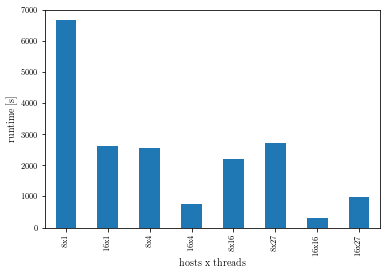

In [11]:
ax = frames['program_run'] \
    .loc[lambda x: x.node_count == 100000000] \
    .sort_values(by='total_workers') \
    .plot.bar(x='worker_label', y='runtime', legend=False)
    
ax.set_ylabel("runtime [s]")
ax.set_xlabel("hosts x threads")

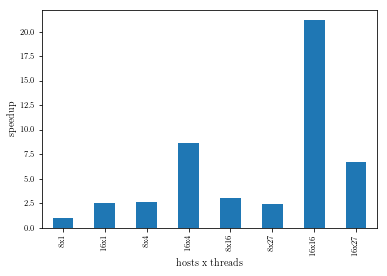

In [10]:
plot_data = frames['program_run'] \
    .loc[lambda x: x.node_count == 100000000] \
    .sort_values(by='total_workers')
    
plot_data['speedup'] = plot_data['runtime'].iloc[0] / plot_data['runtime']
    
ax = plot_data.plot.bar(x='worker_label', y='speedup', legend=False)
    
ax.set_ylabel("speedup")
ax.set_xlabel("hosts x threads")

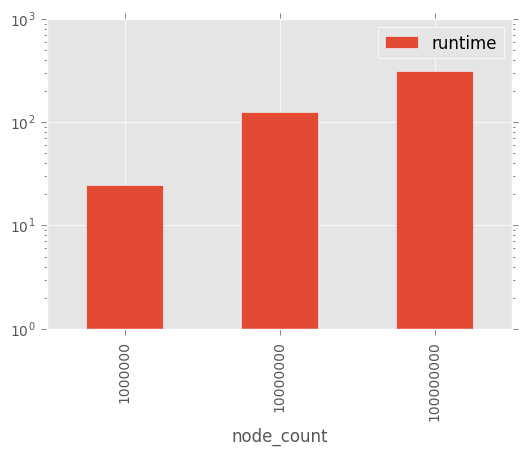

In [87]:
tmp = frames['program_run'] \
    .loc[lambda x: x.workers_per_host == 16] \
    .sort_values(by='node_count')
    
tmp = tmp[tmp.apply(lambda x: int(log(x['node_count'] / 1000000, 10)) == int(log(x['hosts'], 2)) / 2, axis=1)]

tmp.plot.bar(x='node_count', y='runtime', log=True)

In [49]:
frames['program_run'] \
    .sort_values(by='total_workers') \
    .groupby(['graph', 'worker_label'])['runtime'].mean().unstack('worker_label')

worker_label,16x1,16x16,16x27,16x4,1x1,1x16,1x27,1x4,2x1,2x16,2x27,2x4,4x1,4x16,4x27,4x4,8x1,8x16,8x27,8x4
graph,,,,,,,,,,,,,,,,,,,,
/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_1000000-preprocessed-*.bin,NaN,NaN,NaN,NaN,279.148186,23.398281,16.332117,102.334275,172.047172,35.999904,68.558221,48.847658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_10000000-preprocessed-*.bin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1854.450354,191.847318,168.191331,516.737337,1012.113526,124.109318,NaN,276.466337,491.410053,75.633823,NaN,137.884423
/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_100000000-preprocessed-*.bin,2618.313254,314.738288,995.498393,769.812139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6656.282128,2213.329716,2712.852347,2543.904597


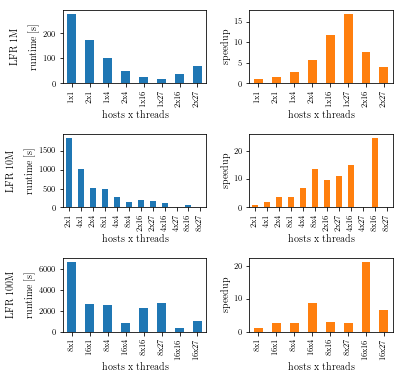

In [41]:
fig, axes = plt.subplots(3, 2, figsize=(textwidth_to_inch(1), textwidth_to_inch(1)));
plt.subplots_adjust(wspace=0.3, hspace=0.7);

pad = 5

for i, node_count in [(0, 1000000), (1, 10000000), (2, 100000000)]:
    label = "LFR {}M".format(int(node_count / 1000000))
    
    plot_data = frames['program_run'] \
        .loc[lambda x: x.node_count == node_count] \
        .sort_values(by='total_workers')
    plot_data['speedup'] = plot_data['runtime'].iloc[0] / plot_data['runtime']
    
    plot_data.plot.bar(x='worker_label', y='runtime', legend=False, ax=axes[i][0])
    axes[i][0].set_ylabel("runtime [s]")
    axes[i][0].set_xlabel("hosts x threads")
    
    plot_data.plot.bar(x='worker_label', y='speedup', legend=False, ax=axes[i][1], color='C1')
    axes[i][1].set_ylabel("speedup")
    axes[i][1].set_xlabel("hosts x threads")
    
    axes[i][0].annotate(label, xy=(0, 0.5), xytext=(-axes[i][0].yaxis.labelpad - pad, 0),
                xycoords=axes[i][0].yaxis.label, textcoords='offset points',
                ha='right', va='center', rotation=90)
    
savefig("lp_scaling")